# Performing SGOOP on a Monte Carlo simulation

*In this notebook, we'll demonstrate how the `sgoop` Python library can be used to perform spectral gap optimization of order parameters (SGOOP) on data from a simple Monte Carlo simulation.*

---

## preparing our environment
First, we import a few libraries that are generally useful for scientific computation and data visualization in Python. 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## creating model data

Next we define the first three-well potential function used in the [preprint by Zach Smith et al](https://www.biorxiv.org/content/early/2018/10/10/438549). We call the function `single_sgoop_potential` because we expect a single round of SGOOP will be sufficient to identify a 1-dimensional RC that effectively distinguishes between all 3 wells.

In [5]:
# define model potential
def single_sgoop_potential(x, y):
    return (
        -12 * np.exp(-4.5 * np.square(x + 0.75) - 3 * np.square(y + 0.5))
        - 16 * np.exp(-2 * np.square(x) - 2 * np.square(y - 1))
        - 12 * np.exp(-4.5 * np.square(x - 0.75) - 3 * np.square(y + 0.5))
        + 0.05 * (np.power(x, 6) + np.power(y, 6))
    )

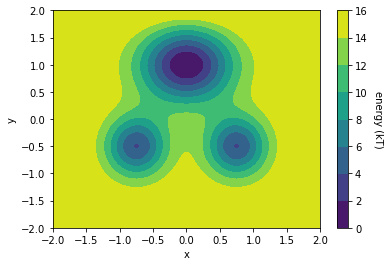

In [9]:
# create range of x and y values, and calculate 2D potential energy surface
xaxis = np.linspace(-2.0, 2.0, 100)
yaxis = np.linspace(-2.0, 2.0, 100)
potential_energy_surface = single_sgoop_potential(
    xaxis[:, None], yaxis[None, :]
) 

# shift and clip high energy values for a prettier visualization
max_val = 16
shifted_pes = potential_energy_surface - potential_energy_surface.min()
shifted_pes[shifted_pes > max_val] = max_val

# plot potential energy surface
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('energy (kT)', rotation=270)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# with Monte Carlo simulation

### running a monte carlo simulation

In [2]:
import random


def boltzmann_prob(pos0, pos1, potential, kt):
    e0 = potential(*pos0.T) 
    e1 = potential(*pos1.T)
    if e1 < e0:
        return 1.0
    return np.exp((e0 - e1) / kt)


def monte_carlo_simulation(
    potential,
    pos_0=(0, 0),
    step_size=(0.04, 0.04), 
    num_steps=50000, 
    kt=1.0
):
    pos = np.array(pos_0)
    results = np.ndarray([num_steps, 2])
    for idx in range(num_steps):
        step = np.array(
            random.choice(
                [(1, 0), (-1, 0),
                 (1, 1), (-1, 1),
                 (1, -1), (-1, -1),
                 (0, 1), (0, -1)]
            )
        ) * np.array(step_size)
        new_pos = pos + step
        prob = boltzmann_prob(pos, new_pos, potential, kt)
        if prob >= np.random.random():
            pos = new_pos
        results[idx, :] = pos
    return results

In [7]:
# set random seed for reproducibility
np.random.seed(24)
# perform md simulation
simulation_results = monte_carlo_simulation(
    single_sgoop_potential, kt=3, num_steps=100000
)

(-2, 2)

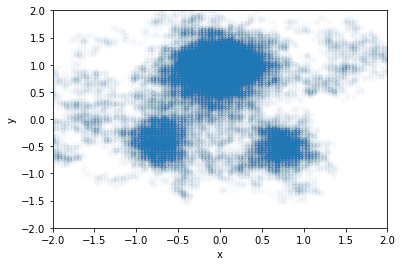

In [8]:
monte_carlo_traj = pd.DataFrame(simulation_results, columns=['x', 'y'])
monte_carlo_traj.plot.scatter(0, 1, alpha=0.01)
plt.ylim([-2, 2])
plt.xlim([-2, 2])

In [9]:
monte_carlo_traj['weights'] = np.exp(
    -single_sgoop_potential(
        monte_carlo_traj['x'].values, monte_carlo_traj['y'].values
    )
)

# finding optimal cv with sgoop

In [10]:
# specify columns you want to require
sgoop_params = {
    # define parameters for probability estimation
    'rc_bins': 50,
    # 'kde_bw': 0.01,
    # define parameters for spectral gap calculation
    'd': 4,
    'wells': 3,
    'diffusivity': 1.0
}

In [11]:
from sgoop.sgoop import rc_eval
from sgoop.utilities import angle_to_rc

# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    sg[idx] = rc_eval(
        rc,
        monte_carlo_traj[['x', 'y']],
        sgoop_params,
        weights=monte_carlo_traj['weights'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

rc 0:  angle:  0.000  sg:  0.032
rc 1:  angle:  0.083  sg:  0.006
rc 2:  angle:  0.165  sg:  0.005
rc 3:  angle:  0.248  sg:  0.020
rc 4:  angle:  0.331  sg:  0.019
rc 5:  angle:  0.413  sg:  0.022
rc 6:  angle:  0.496  sg:  0.022
rc 7:  angle:  0.579  sg:  0.018
rc 8:  angle:  0.661  sg:  0.017
rc 9:  angle:  0.744  sg:  0.010
rc10:  angle:  0.827  sg:  0.001
rc11:  angle:  0.909  sg:  0.024
rc12:  angle:  0.992  sg:  0.054
rc13:  angle:  1.075  sg:  0.063
rc14:  angle:  1.157  sg:  0.058
rc15:  angle:  1.240  sg:  0.048
rc16:  angle:  1.323  sg:  0.032
rc17:  angle:  1.405  sg:  0.010
rc18:  angle:  1.488  sg:  0.003
rc19:  angle:  1.571  sg:  0.003
optimized RC: [0.47594739 0.87947375]
spectral gap: 0.0634760958687205


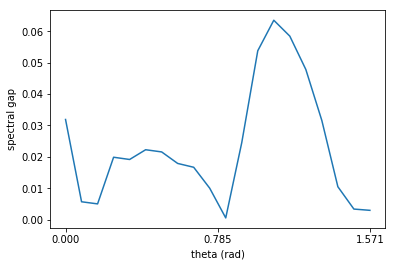

In [12]:
plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

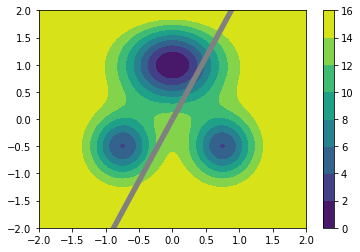

In [15]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

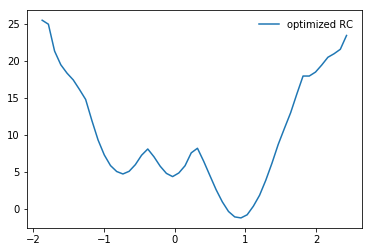

In [16]:
from sgoop.sgoop import md_prob

############
# pmf plot #
############
opt_prob, opt_grid = md_prob(
    opt_rc,
    monte_carlo_traj[['x', 'y']],
    monte_carlo_traj['weights'],
    sgoop_params.get('rc_bins'),
    sgoop_params.get('kde_bw'),
)

# initialize plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot pmf from probability
plt.plot(opt_grid, -np.ma.log(opt_prob), label="optimized RC")

plt.legend(frameon=False)
plt.show()

In [ ]:
def double_sgoop_potential(x, y):
    return (
        -12 * np.exp(-4.5 * np.square(x + 0.55) - 3 * np.square(y + 0.5))
        - 16 * np.exp(-2 * np.square(x) - 2 * np.square(y - 1))
        - 12 * np.exp(-4.5 * np.square(x - 0.55) - 3 * np.square(y + 0.5))
        + 0.05 * (np.power(x, 6) + np.power(y, 6))
    )

In [17]:
# set random seed for reproducibility
np.random.seed(24)
# perform md simulation

simulation_results = monte_carlo_simulation(
    double_sgoop_potential, kt=3, num_steps=100000
)

(-2, 2)

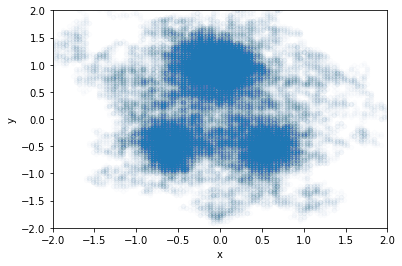

In [18]:
monte_carlo_traj = pd.DataFrame(simulation_results, columns=['x', 'y'])
monte_carlo_traj.plot.scatter(0, 1, alpha=0.01)
plt.ylim([-2, 2])
plt.xlim([-2, 2])

In [19]:
monte_carlo_traj['weights'] = np.exp(
    -single_sgoop_potential(
        monte_carlo_traj['x'].values, monte_carlo_traj['y'].values
    )
)

In [20]:
# specify columns you want to require
sgoop_params = {
    # define parameters for probability estimation
    'rc_bins': 50,
    # 'kde_bw': 0.01,
    # define parameters for spectral gap calculation
    'd': 4,
    'wells': 3,
    'diffusivity': 1.0
}

In [21]:
from sgoop.sgoop import rc_eval
from sgoop.utilities import angle_to_rc

# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    sg[idx] = rc_eval(
        rc,
        monte_carlo_traj[['x', 'y']],
        sgoop_params,
        weights=monte_carlo_traj['weights'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

rc 0:  angle:  0.000  sg:  0.040
rc 1:  angle:  0.083  sg:  0.006
rc 2:  angle:  0.165  sg:  0.006
rc 3:  angle:  0.248  sg:  0.008
rc 4:  angle:  0.331  sg:  0.007
rc 5:  angle:  0.413  sg:  0.008
rc 6:  angle:  0.496  sg:  0.007
rc 7:  angle:  0.579  sg:  0.007
rc 8:  angle:  0.661  sg:  0.006
rc 9:  angle:  0.744  sg:  0.005
rc10:  angle:  0.827  sg:  0.025
rc11:  angle:  0.909  sg:  0.048
rc12:  angle:  0.992  sg:  0.059
rc13:  angle:  1.075  sg:  0.060
rc14:  angle:  1.157  sg:  0.055
rc15:  angle:  1.240  sg:  0.042
rc16:  angle:  1.323  sg:  0.022
rc17:  angle:  1.405  sg:  0.001
rc18:  angle:  1.488  sg:  0.006
rc19:  angle:  1.571  sg:  0.001
optimized RC: [0.47594739 0.87947375]
spectral gap: 0.05978381827602908


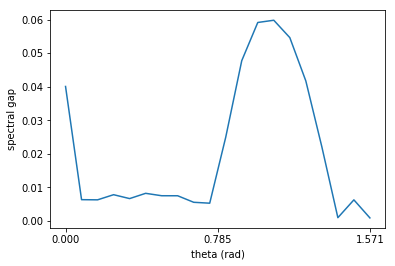

In [22]:
plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

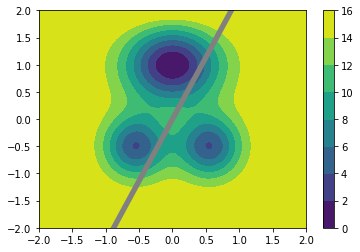

In [25]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

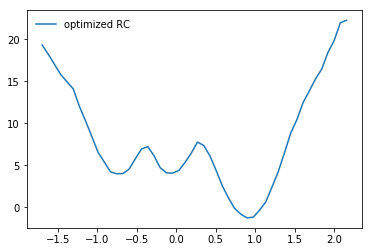

In [26]:
from sgoop.sgoop import md_prob

############
# pmf plot #
############
opt_prob, opt_grid = md_prob(
    opt_rc,
    monte_carlo_traj[['x', 'y']],
    monte_carlo_traj['weights'],
    sgoop_params.get('rc_bins'),
    sgoop_params.get('kde_bw'),
)

# initialize plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot pmf from probability
plt.plot(opt_grid, -np.ma.log(opt_prob), label="optimized RC")

plt.legend(frameon=False)
plt.show()